<img src="./assets/Daraz-Symbol.png" alt="Logo" style="float:left;width:100px;"/>

# Daraz Knowledge Graph using Neo4j

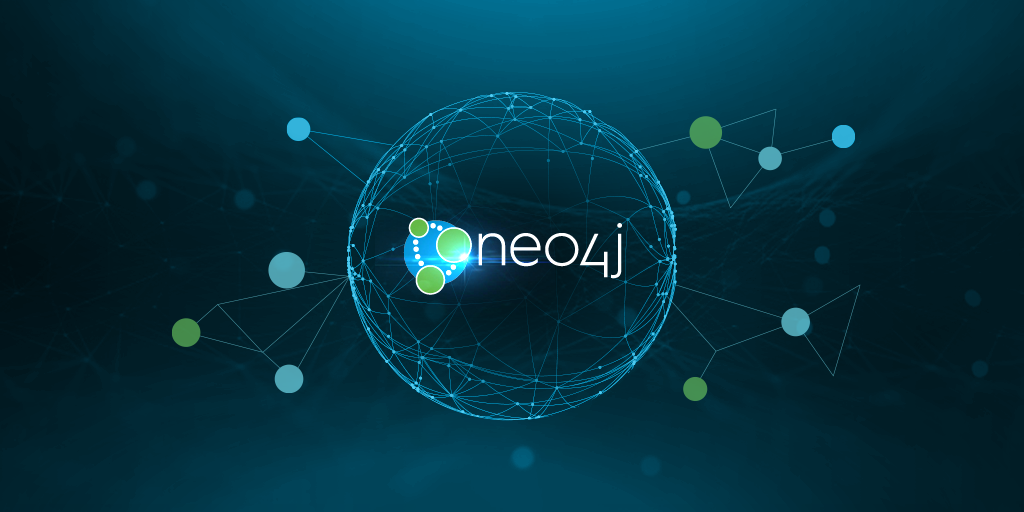

Neo4j is a popular graph database management system that is used for storing, querying, and managing graph data. It is a highly scalable and flexible database that is designed to handle large and complex datasets, making it an ideal choice for applications that require high-performance graph data processing.

Neo4j also provides a powerful query language called Cypher, which is specifically designed for querying graph data. Cypher allows users to express complex graph queries in a simple and intuitive way, making it easy to explore and analyze large graph datasets.

In this notebook, we are going to use neo4j to store and represent knowledge graph from the scraped data from daraz.com.np/smartphones, and will execute some queries to get some insights.

# Neo4j Driver

Since, Neo4j is a database, particularly a graph database, so to communicate with it using python, we need a package. There are various options for this, but we will be using [Neo4j-driver](https://pypi.org/project/neo4j/).

There are several Python packages available for connecting to Neo4j, each with its own unique features and capabilities. Some of the most popular Python packages for connecting to Neo4j include:

- **py2neo**: A full-featured Python library for working with Neo4j. It provides a high-level object-oriented API for interacting with Neo4j, including support for data modeling, querying, and graph analysis.

- **neo4j-driver**: The official Neo4j driver for Python, which provides a low-level API for connecting to and interacting with Neo4j. It supports both synchronous and asynchronous communication with the database and allows for fine-grained control over transaction management.

- **neomodel**: A high-level object-oriented modeling library that provides a simplified API for working with Neo4j. It supports data modeling using Python classes and provides an expressive query API for querying graph data.

- **pygraphistry**: A visualization library that provides an interactive interface for exploring graph data stored in Neo4j. It allows users to create visualizations of graph data directly from Python, making it easy to explore and analyze complex graph datasets.

- **igraph**: A general-purpose graph library that provides algorithms and data structures for working with graphs. It includes support for importing and exporting data to and from Neo4j, making it a useful tool for graph analysis and visualization.

These are just a few examples of the many Python packages available for working with Neo4j. The choice of package will depend on the specific needs of the project and the level of control and functionality required.


In [1]:
# !pip install neo4j

In [2]:
from neo4j import GraphDatabase

In [3]:
driver = GraphDatabase.driver("bolt://localhost:7687",
                              auth=("neo4j", "123456789"))

In [4]:
def is_connected(driver):
    # Verify the connectivity
    try:
        driver.verify_connectivity()
        print("Connection is active")
    except Exception as e:
        print("Connection failed: ", e)

In [5]:
is_connected(driver)

Connection failed:  Couldn't connect to localhost:7687 (resolved to ()):
Failed to establish connection to ResolvedIPv4Address(('127.0.0.1', 7687)) (reason [Errno 111] Connection refused)


In [49]:
type(driver)

neo4j._sync.driver.BoltDriver

# Load JSON file

Let's transform JSON file into pandas dataframe, from where we are going to load data into neo4j.

In [8]:
import json
import pandas as pd

ImportError: Unable to import required dependencies:
pytz: No module named 'pytz'

In [6]:
with open("../archives/daraz_scraped_data_v3.json", 'r') as f:
    raw_data = json.load(f)

In [7]:
len(raw_data)

880

In [8]:
raw_data[0]

{'name': 'realme 10 Pro Plus | 8GB RAM & 128GB ROM',
 'url': 'https://www.daraz.com.np/products/realme-10-pro-plus-8gb-ram-128gb-rom-i123076745-s1033443679.html?search=1',
 'rating': 0.0,
 'review': 0.0,
 'brand_name': 'RealMe',
 'brand_id': '202391',
 'seller_name': 'NS Traders Suppliers',
 'description': {'os': [['realme ui 4.0', 'based on android 13']],
  'rear camera': [['108mp prolight camera + 8mp ultra-wide angle camera +  2mp macro camera']]},
 'details': {'Brand': 'RealMe',
  'SKU': '123076745_NP-1033443679',
  'Battery Capacity': '4000 - 4999 mAh',
  'Screen Size (inches)': '6.6 - 7 Inch',
  'Build Type': 'Not Specified',
  'Camera Front (Megapixels)': '16MP',
  'Camera Back (Megapixels)': '108MP+8MP+2MP',
  'Number Of Cameras': '4',
  'Display Protection': 'Glass',
  'Model Year': '2022',
  'Network Connections': '4G,3G,2G,5G',
  'Fast Charging': '67W Supervooc Charge',
  'Wireless Charging': 'No',
  'Number of SIM Slots': '2',
  'Charger Type': 'Type-C',
  'Flash': 'Yes',
 

# Transform JSON into DataFrame

In [9]:
from tqdm import tqdm
import re

In [45]:
COLUMNS=['name','rating', 'review','url', 'brand_id',
         'seller_name', 'variant_hash', 'color_family', 'RAM Memory', 
         'Storage Capacity', 'price']

DETAIL_FIELD = ['Brand', 'Number Of Cameras','Model Year', 
                'Wireless Charging','SIM Type','Battery Capacity', 
                'Camera Front (Megapixels)',]

# defining mapper that map devanagari to english script
eng_to_np = {'Color Family': 'रंग परिवार', 
             'RAM Memory': 'र्याम मेमोरी',
             'Storage Capacity': 'भण्डारण क्षमता'}

In [46]:
def extract_product_name(raw_name):
    '''
        it will return the actual product name by clipping it from the raw_text
        
        args:
            raw_name: string
        returns:
            clipped_name: string
        
        example:
        >> raw_name = "realme 10 Pro Plus | 8GB RAM & 128GB ROM"
        >> extract_product_name(raw_name)
        "realme 10 Pro Plus"
        
    '''
    pattern  = "([\w\s]*)"
    matches = re.search(pattern, raw_name)
    clipped_name = matches.groups(1)[0].strip()
    if len(clipped_name) > 20:
        return clipped_name[:20]
    return clipped_name

In [12]:
def create_dataframe(json_data, columns, detail_field, eng_to_np):
    # create empty dataframe
    df = pd.DataFrame(columns=columns+detail_field)
    # Transforme the JSON into dataframe
    variant_ID = 0
    for product_dict in tqdm(json_data):
        product = {}
        
        for column in columns:
            if column == 'name':
                product[column] = extract_product_name(product_dict[column])
            else:
                product[column] = product_dict.get(column, 'Not Specified')
     
        for column in detail_field:
            product[column] = product_dict['details'].get(column, 'Not Specified')
        
        for price_n_prop in product_dict['details'].get('price_n_prop', []):
            color_family = price_n_prop['props'].get('Color Family', '')
            RAM = price_n_prop['props'].get('RAM Memory', '')
            storage = price_n_prop['props'].get('Storage Capacity', '')

            if color_family == '' and RAM =='' and  storage == '':
                color_family = price_n_prop['props'].get(eng_to_np['Color Family'], 'Not Specified')
                RAM = price_n_prop['props'].get(eng_to_np['RAM Memory'], 'Not Specified')
                storage = price_n_prop['props'].get(eng_to_np['Storage Capacity'], 'Not Specified')

            price_text = price_n_prop['price_info']['salePrice']['text']
            price_value = price_n_prop['price_info']['salePrice']['value']
            
            variant_display_name = f'variant: {variant_ID}' 

            # append row
            product.update({'price': price_text,
                            'price_value': price_value,
                            'color_family': color_family, 
                            'RAM Memory': RAM,
                            'Storage Capacity': storage,
                            'variant_hash': variant_display_name})
            series = pd.Series(product)
            
            
            df = df.append(series, ignore_index=True)
            variant_ID += 1
    return df

In [13]:
df = create_dataframe(raw_data, COLUMNS, DETAIL_FIELD, eng_to_np)

100%|████████████████████████████████████████| 880/880 [00:03<00:00, 237.67it/s]


In [14]:
df.head()

,name,rating,review,url,brand_id,seller_name,variant_hash,color_family,RAM Memory,Storage Capacity,price,Brand,Number Of Cameras,Model Year,Wireless Charging,SIM Type,Battery Capacity,Camera Front (Megapixels),price_value
0,realme 10 Pro Plus,0.0,0.0,https://www.daraz.com.np/products/realme-10-pr...,202391,NS Traders Suppliers,variant: 0,Hyperspace Gold,8GB,128GB,"Rs. 45,447",RealMe,4,2022,No,Nano,4000 - 4999 mAh,16MP,45447.0
1,Samsung Galaxy A53 5,5.0,1.0,https://www.daraz.com.np/products/samsung-gala...,4198,Electronics Planet,variant: 1,Multicolor,8GB,128GB,"Rs. 56,500",Samsung,2,2021,Not Specified,Not Specified,Not Specified,Not Specified,56500.0
2,Realme Narzo 50,0.0,0.0,https://www.daraz.com.np/products/realme-narzo...,124051041,S&P Gadgets Hub,variant: 2,Blue,4GB,64GB,"Rs. 23,899",narzo by realme,4,2022,No,Not Specified,5000 - 5999 mAh,16MP,23899.0
3,Realme Narzo 50,0.0,0.0,https://www.daraz.com.np/products/realme-narzo...,124051041,S&P Gadgets Hub,variant: 3,Black,4GB,64GB,"Rs. 23,899",narzo by realme,4,2022,No,Not Specified,5000 - 5999 mAh,16MP,23899.0
4,Realme Narzo 50,0.0,0.0,https://www.daraz.com.np/products/realme-narzo...,124051041,S&P Gadgets Hub,variant: 4,Blue,6GB,128GB,"Rs. 27,499",narzo by realme,4,2022,No,Not Specified,5000 - 5999 mAh,16MP,27499.0


In [15]:
df.tail()

,name,rating,review,url,brand_id,seller_name,variant_hash,color_family,RAM Memory,Storage Capacity,price,Brand,Number Of Cameras,Model Year,Wireless Charging,SIM Type,Battery Capacity,Camera Front (Megapixels),price_value
1606,COLORS PRIDE 5C,0.0,0.0,https://www.daraz.com.np/products/colors-pride...,129754,s.s trading,variant: 1606,Gold,1GB,8GB,"Rs. 7,595",COLORS,2,2018,No,Standard,2000 - 2999 mAh,5mp,7595.0
1607,vivo Y01,0.0,0.0,https://www.daraz.com.np/products/vivo-y01-2gb...,33353,Apex Telemart Pvt Ltd,variant: 1607,Elegant Black,2GB,32GB,"Rs. 13,999",Vivo,2,2021,No,Not Specified,5000 - 5999 mAh,5MP f/2.2,13999.0
1608,vivo Y01,0.0,0.0,https://www.daraz.com.np/products/vivo-y01-2gb...,33353,Apex Telemart Pvt Ltd,variant: 1608,Sapphire Blue,2GB,32GB,"Rs. 13,999",Vivo,2,2021,No,Not Specified,5000 - 5999 mAh,5MP f/2.2,13999.0
1609,OnePlus 11 5G,0.0,0.0,https://www.daraz.com.np/products/oneplus-11-5...,12944,246Impex,variant: 1609,Green,16GB,256GB,"Rs. 134,999",OnePlus,4,2023,No,Nano,5000 - 5999 mAh,16MP,134999.0
1610,Apple iPhone 14 256G,0.0,0.0,https://www.daraz.com.np/products/apple-iphone...,4178,246Impex,variant: 1610,Black,6GB,256GB,"Rs. 156,410",Apple,3,2022,Yes,Nano,3000 - 3999 mAh,12MP,156410.0


# Save dataframe

Let's save the dataframe into archieve.

In [23]:
!cd .. && ls

archives  networkx_kg.png  notebooks


In [24]:
df.to_csv("../archives/daraz_KG.csv")

# Defining Schema for knowledge graph

Determining which entity to set as a node and which one to set as an attribute in a graph database depends on the nature of your data and your use case. However, here are some general guidelines that can help you make this decision:

- Nodes represent entities that are central to your data model and have independent existence. For example, in a social network, users would be represented as nodes because they have their own identity and can exist independently of other entities in the network. On the other hand, attributes represent properties or characteristics of an entity that are not central to the data model, but rather describe or qualify the entity. For example, in a social network, a user's age or occupation would be represented as attributes because they describe the user, but are not central to the structure of the network itself.

- If two entities have a many-to-many relationship, it may be more appropriate to represent the relationship as a separate node with attributes, rather than as attributes of the nodes themselves. For example, in a movie database, if actors can play multiple roles and movies can have multiple actors, it may be more appropriate to represent the relationship between actors and movies as a separate node (e.g., "Role") with attributes such as the character name and the actor's billing order.

- When deciding whether to use an attribute or a separate node, consider whether the attribute has its own properties or relationships. If so, it may be better to represent it as a separate node. For example, in a product catalog, if products have multiple categories, it may be better to represent categories as separate nodes with their own attributes, rather than as attributes of the products themselves, especially if you need to query the data by category.

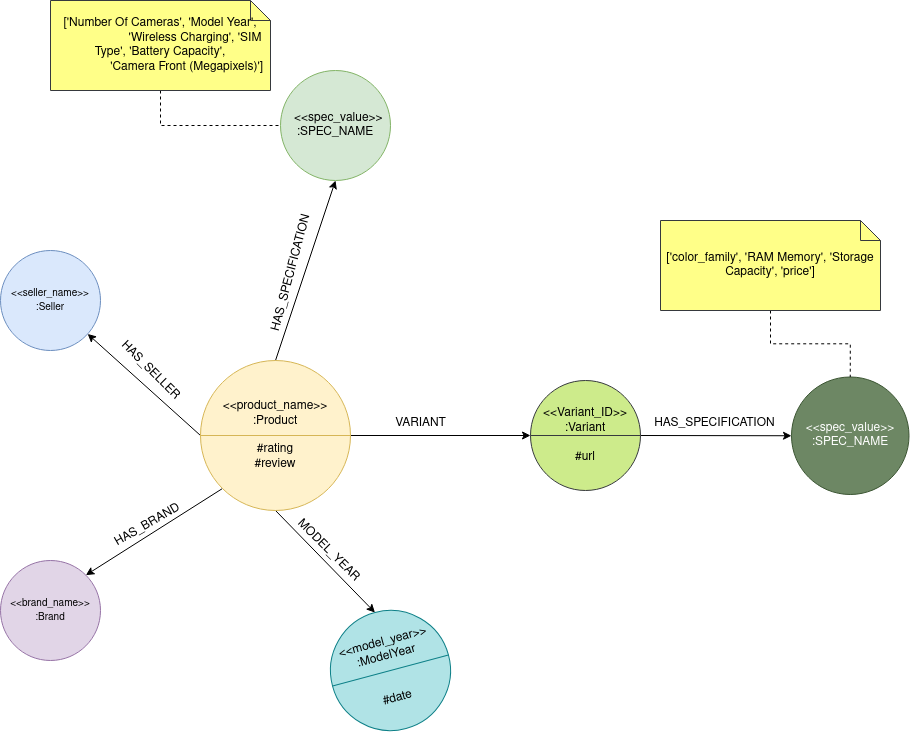

Note that, we can create different schema based on our usecase, for now the above schema meets our requirements. "Color_family" can be linked directly into the product node instead of its variant, but we are not sure if particular color family of a product has different price or not. If we put color_family outside the variant, the influence of it to the price will not be captured. 

# Loading Data inot Neo4j using neo4j driver
Now, it's time to load the data from dataframe into the neo4j.

In [47]:
def clean_label(label):
    token = label.split("(")
    return token[0].strip().replace(" ", "_")

In [34]:
def query_segment_generator(x, label, node):
    prop = ""
    for k, v in x.items():
        prop += f"{k}: ${node}.{k},"
    prop = prop[:-1]   
    seg = "MERGE ("+node+":"+clean_label(label)+" {"+prop+"})"
    return seg

def generate_cypher(node1, node2, relation):
    return (
        query_segment_generator(node1, node1['type'], "node1")+
        "ON CREATE SET node1.name = $node1.name "+
        query_segment_generator(node2, node2['type'], "node2")+
        "ON CREATE SET node2.name = $node2.name "+
        f"MERGE (node1)-[r:{relation['type']}]->(node2)"
        )

def db_insert(src, trg, relationship, session):
    cypher = generate_cypher(src, trg, relationship)
    session.run(cypher, node1=src, node2=trg, rel=relationship)

In [48]:
with driver.session() as session:
        # iterate through each row in the CSV file
        for idx, row in df.iterrows():
            # create RELATION => HAS_BRAND
            src = {'name':row['name'], 'type': 'Product',
                   'rating': row['rating'], 'review': row['review']}
            
            trg = {'name':row['Brand'], 'type':'Brand', 'id':row['brand_id']}
            # create a relationship between the nodes
            relationship = {'type': 'HAS_BRAND'} 
            db_insert(src, trg, relationship, session)
            
            # create RELATION => HAS_SELLER
            trg = {'name': row['seller_name'], 'type':'Seller'}
            relationship = {'type': 'HAS_SELLER'} 
            db_insert(src, trg, relationship, session)
            
            # create  RELATION => HAS_SPECIFICATION
            SPECS = ['Number Of Cameras', 'Wireless Charging', 
                     'SIM Type', 'Battery Capacity', 'Camera Front (Megapixels)']
            
            for spec in SPECS:
                trg = {'name': row[spec], 'type':spec}
                relationship = {'type': 'HAS_SPECIFICATION'}
                db_insert(src, trg, relationship, session)                
                
            # create RELATION => VARIENT
            trg = {'name': 'variant_'+str(idx), 'type':'Variant', 'url':row['url']}
            relationship={'type': 'VARIANT'}
            db_insert(src, trg, relationship, session)
            varient_trg = trg
            
            # create RELATION => MODEL_YEAR
            trg = {'date':row['Model Year'], 'name': row['Model Year'], 'type':'ModelYear'}
            relationship = {'type': 'MODEL_YEAR'}
            db_insert(src, trg, relationship, session)
            
            
            # create RELATION => HAS
            VAR_SPECS = ['color_family', 'RAM Memory', 'Storage Capacity',
                         'price']
            
            for spec in VAR_SPECS:
                if spec == 'price':
                    trg = {'name': row[spec], 'type':spec, 'value': row['price_value']}
                else:
                    trg = {'name': row[spec], 'type':spec}
                    
                relationship = {'type': 'HAS_SPECIFICATION'}
                db_insert(varient_trg, trg, relationship, session)
#             if idx == 30:
#                 break

# Validate Schema

To varify the validation of the schema, we can run the given query in the neo4j-browser. 
```
MATCH (n:Product{name: "Samsung Galaxy A04s"})-[*]->(q)
RETURN n,q
```

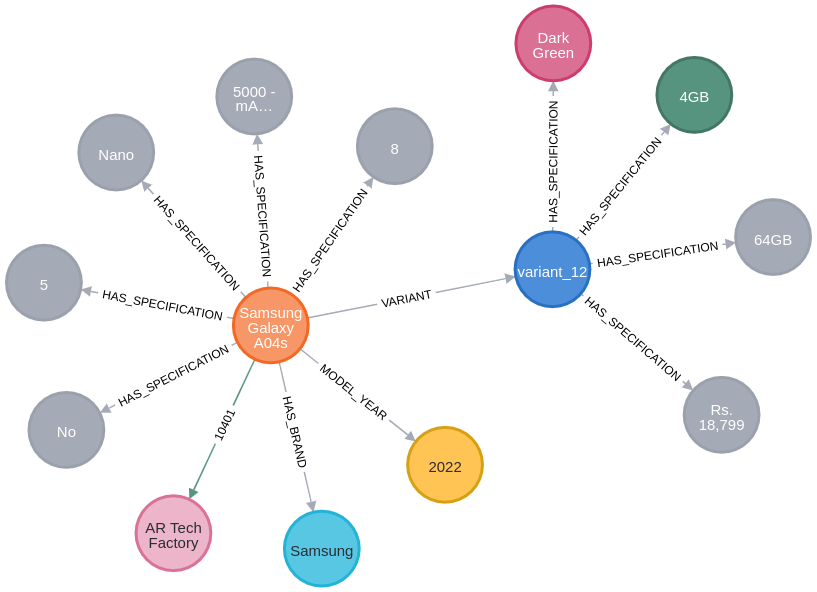

```
MATCH (n:Product{name: "Realme Narzo 50"})-[*]->(q)
RETURN n,q
```

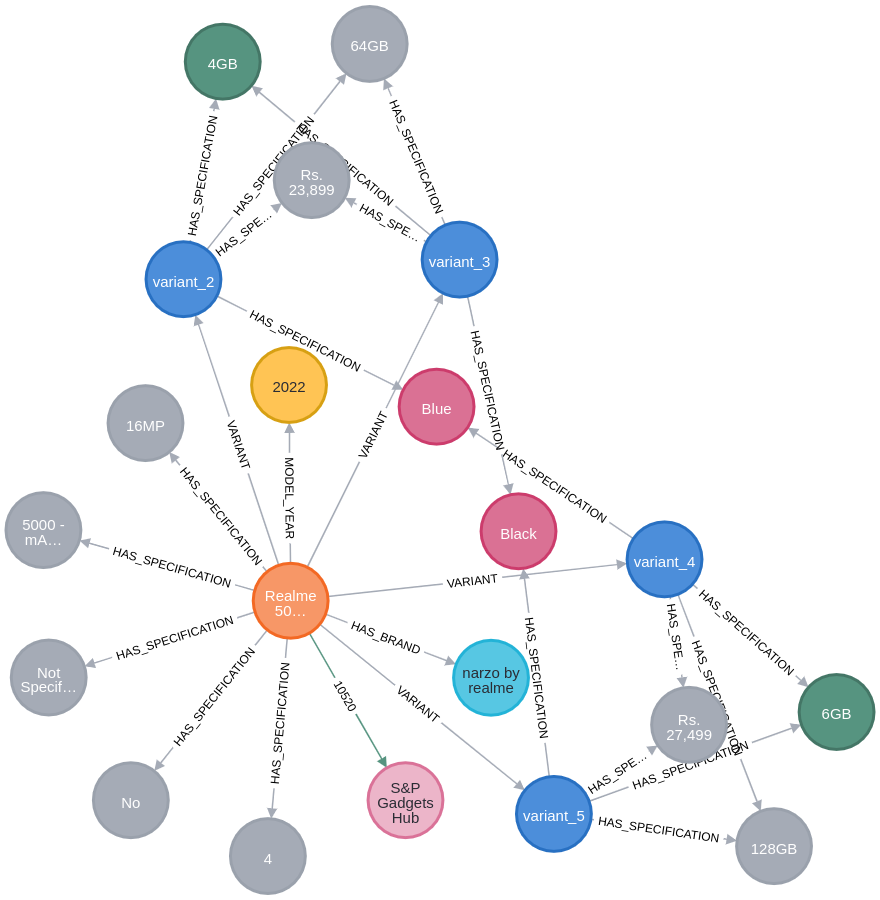

As you can see, the graph inside the neo4j is expected (is matching our schema).
Now, it's time to do some queries

# Querying Knowledge graph

In [50]:
def execute_query(query, driver):
    '''
        execute the query and return the result
        
        args:
            query: string; query_string
            driver: neo4j._sync.driver.BoltDriver
        returns:
            result: list
    '''
    with driver.session() as session:
        result = session.run(query)
        return list(result)

## Find the product whose rating is grater than 2

In [61]:
q = "MATCH (n:Product where n.rating > 2) return n"
result = execute_query(q, driver)
result = [record['n']['name'] for record in result]

In [62]:
print("Number of items: ",len(result))

Number of return items:  156


In [63]:
result[:10]

['vivo Y12s',
 'Samsung Galaxy A33 6',
 'vivo Y1s',
 'vivo V21e',
 'A49 itel 6',
 'OnePlus 10T 5G',
 'Infinix Smart 6',
 'vivo Y15C',
 'Realme 10',
 'Realme C35 Mobile Ph']

## Find the product whose rating is less than 2

In [66]:
q = "MATCH (n:Product where n.rating < 2) return n"
result = execute_query(q, driver)
products = [record['n']['name'] for record in result]
print("Number of items: ",len(products))

Number of items:  185


In [67]:
products[:10]

['Infinix Note 12',
 'Nokia C1 2nd Edition',
 'Honor 50 Lite',
 'Realme C30',
 'Realme C55',
 'Narzo 50',
 'Samsung Galaxy S22 U',
 'Lephone W10',
 'LAVA Z3',
 'realme narzo 50i Pri']

## query distinct model year in the datasete

In [68]:
q = "MATCH (n:Product)-[:MODEL_YEAR]->(m:ModelYear) RETURN distinct(m)"
result = execute_query(q, driver)

In [69]:
model_years = [record['m']['date'] for record in result]
model_years

['2017',
 '2022',
 '2021',
 '2018',
 '2023',
 '2020',
 '2016',
 '2019',
 'Not Specified']

## query all the product of Redmi from model year 2022

In [70]:
q = '''Match (n:Product)-[:HAS_BRAND]->(m:Brand {name:'Redmi'}),
       (n:Product)-[:MODEL_YEAR]-(y:ModelYear {date:'2022'})
       RETURN distinct(n)'''

result = execute_query(q, driver)

In [71]:
products = [record['n']['name'] for record in result]
print("products from 2022: ", products)

products from 2022:  ['Redmi 10', 'Redmi 10', 'Redmi A1 Plus', 'Redmi A1', 'Redmi Note 11 Snapdr']


## query the product that are begin sold by multiple vendors


In [238]:
q = '''MATCH (x:Seller)<-[r:HAS_SELLER]-(p:Product)-[r2:HAS_SELLER]->(y:Seller)
       RETURN x,p,y'''
result = execute_query(q, driver)

In [245]:
from collections import defaultdict

product_vendor = defaultdict(list)
for record in result:
    product_vendor[record['p']['name']].extend([record['x']['name'], record['y']['name']])
#     print(record['x']['name'],"|", record['y']['name'],"|-->", record['b']['name'])
product_vendor = dict(product_vendor)

In [251]:
import pprint

pprint.pprint(product_vendor)

{'Apple iPhone 14': ['Oliz Store', 'iSure.', 'iSure.', 'Oliz Store'],
 'Apple iPhone 14 Plus': ['ARUN ELECTRONICS',
                          'evostore',
                          'Oliz Store',
                          'evostore',
                          'evostore',
                          'ARUN ELECTRONICS',
                          'Oliz Store',
                          'ARUN ELECTRONICS',
                          'ARUN ELECTRONICS',
                          'Oliz Store',
                          'evostore',
                          'Oliz Store'],
 'Apple iPhone 14 Pro': ['Oliz Store',
                         'evostore',
                         'iSure.',
                         'ARUN ELECTRONICS',
                         'ARUN ELECTRONICS',
                         'iSure.',
                         'evostore',
                         'Oliz Store'],
 'Apple iPhone 14 Pro ': ['246Impex',
                          'ARUN ELECTRONICS',
                          'ARUN ELEC

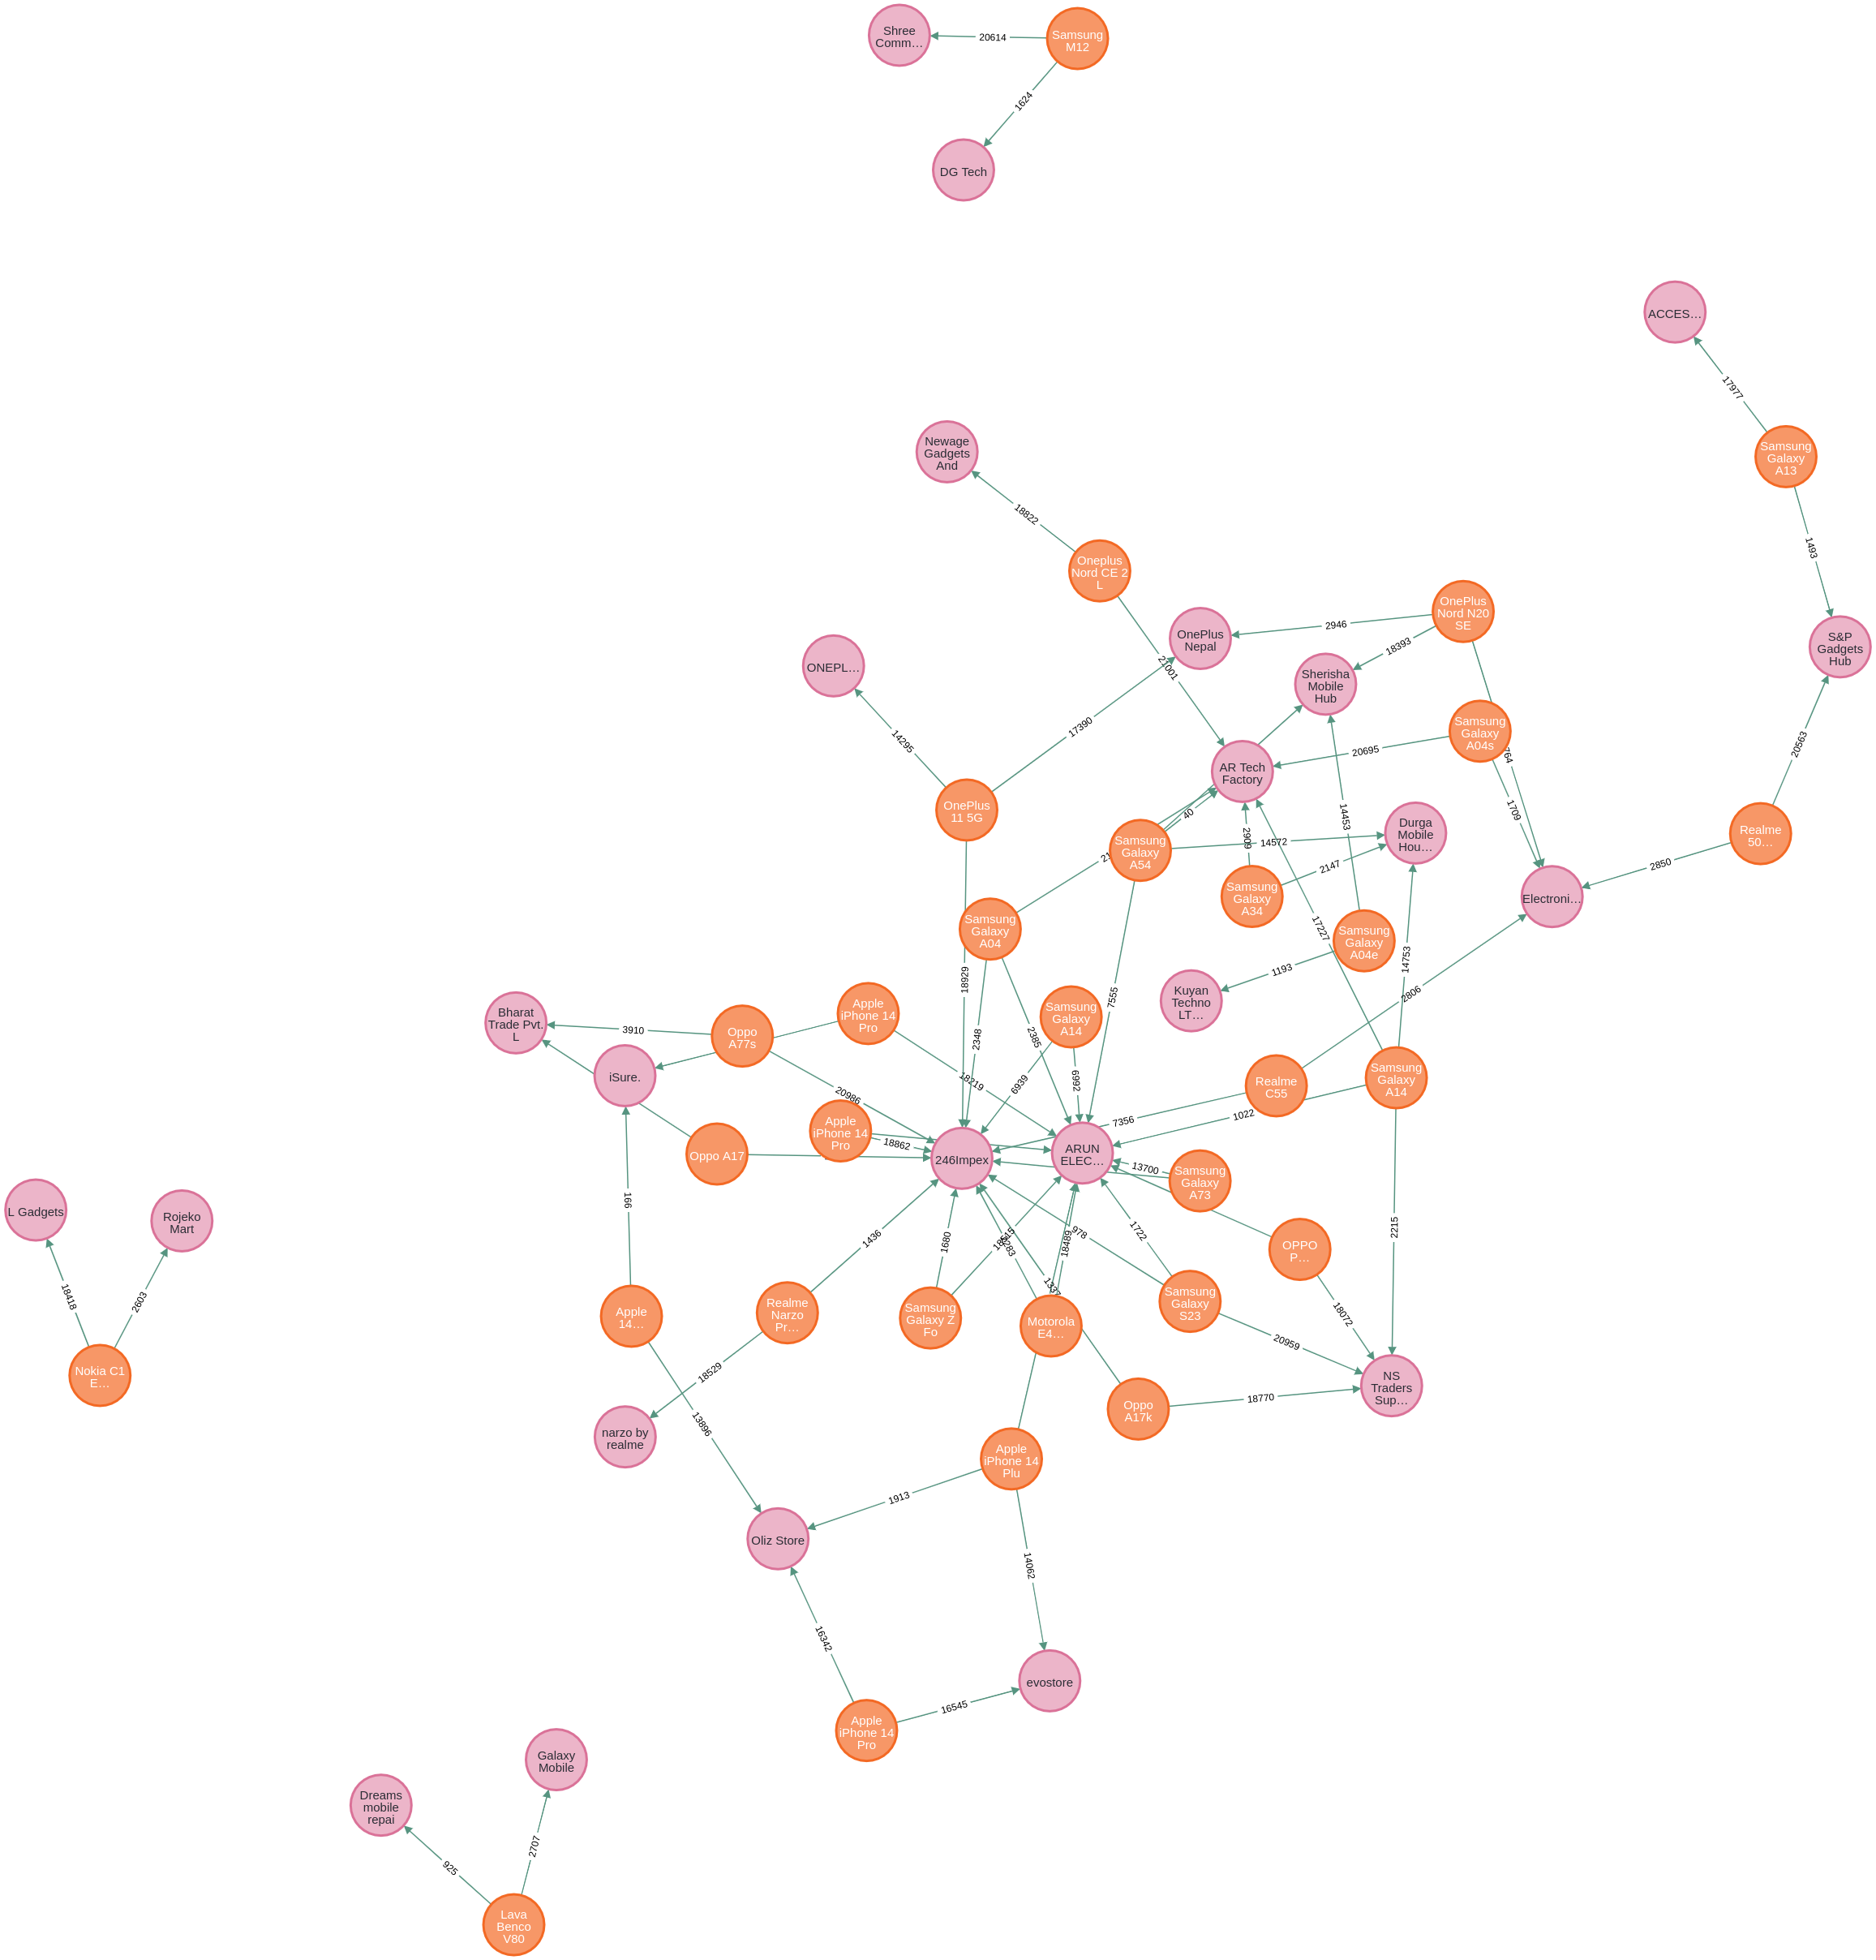
**figure: the query result from neo4j-browser**